In [1]:

import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 326s 0us/step


In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [4]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [7]:
print(f'===> number of images: {len(img_name_vector)}\n===> number of captions: {len(train_captions)}')

===> number of images: 30016
===> number of captions: 30016


In [8]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [9]:
def decode_sequence(encoded_text):
  lst = []
  for i in encoded_text[0]:
    lst.append(tokenizer.index_word[i])
  return ' '.join(lst)

In [10]:
def tokenize_sequence(sequence):
  tokezied =  tokenizer.texts_to_sequences(sequence)

In [97]:
WIDTH, HEIGHT = 28, 28
import cv2
train_captions = list()
train_images = list()
for batch_captions, batch_images in zip(cap_vector, img_name_vector):
  train_captions.append(batch_captions)
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=1)
  img = tf.image.resize(img, (64, 64))
  img = np.array(img)
  train_images.append(img)
  # image = np.array(Image.open(batch_images).convert('L'))

  # print(image.shape)
  # image = cv2.resize(image, (28,28))
  # image = image[:,np.newaxis]
  # print(image.shape)
  # # resized_img = img.resize((WIDTH, HEIGHT))
  # image = np.array(resized_img).astype('float32')
  # image = (image - 127.5) / 127.5


In [108]:
train_images = np.array(train_images)

In [5]:
from tensorflow.keras import layers

In [6]:
GenModel = tf.keras.Sequential()
GenModel.add(layers.Dense(8*8*256, use_bias=False, input_shape=[48,]))
GenModel.add(layers.BatchNormalization())
GenModel.add(layers.LeakyReLU())

GenModel.add(layers.Reshape((8, 8, 256)))

GenModel.add(layers.Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same', use_bias=False))
GenModel.add(layers.BatchNormalization())
GenModel.add(layers.LeakyReLU())

GenModel.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
GenModel.add(layers.BatchNormalization())
GenModel.add(layers.LeakyReLU())

GenModel.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

In [7]:
# DisModel = tf.keras.Sequential()
# DisModel.add(layers.Input(shape=(None, 32, 32, 1)))
# DisModel.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
# DisModel.add(layers.LeakyReLU())
# DisModel.add(layers.Dropout(0.3))

# DisModel.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
# DisModel.add(layers.LeakyReLU())
# DisModel.add(layers.Dropout(0.3))

# DisModel.add(layers.Flatten())
# DisModel.add(layers.Dense(1))

# DisModel1 = tf.keras.Sequential()
# DisModel1.add(layers.Input(shape=(32,32,1)))
# DisModel1.add(layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False))
# DisModel1.add(layers.BatchNormalization())
# DisModel1.add(layers.LeakyReLU())
# DisModel1.add(layers.Dropout(0.2))

# DisModel1.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
# DisModel1.add(layers.BatchNormalization())
# DisModel1.add(layers.LeakyReLU())
# DisModel1.add(layers.Dropout(0.2))

# DisModel1.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
# DisModel1.add(layers.BatchNormalization())
# DisModel1.add(layers.LeakyReLU())
# DisModel1.add(layers.Dropout(0.2))

# DisModel1.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
# DisModel1.add(layers.BatchNormalization())
# DisModel1.add(layers.LeakyReLU())
# DisModel1.add(layers.Dropout(0.2))

# DisModel1.add(layers.Flatten())
# DisModel1.add(layers.Dense(1))

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(46,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(64, 64, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
generator = make_generator_model()

In [8]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
learning_rate = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [129]:
@tf.function
def train_step(images,captions):
  with tf.device('/device:GPU:0'):   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      print('start')
      generated_images = generator(captions, training=True)
      print('gen fin')
      real_output = discriminator(images, training=True)
      print('realoutputtrain')
      fake_output = discriminator(generated_images, training=True)
      
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [130]:
print(np.array(train_images).shape)

(30016, 64, 64, 1)


In [131]:
print(train_images.shape)

(30016, 64, 64, 1)


In [134]:
epochs = 1000
batch_size = 1000

def train(epochs):
  for epoch in range(1, epochs + 1):
    print(epoch)
    start = time.time()

    for i in range(len(train_captions)//batch_size):
      print(f'batch no {i + 1}')
      image_batch = train_images[i*batch_size:(i+1)*batch_size]
      caption_batch = np.array(train_captions[i*batch_size:(i+1)*batch_size])
      train_step(image_batch, caption_batch)
  
    if (epoch) % 20 == 0:
      generator.save_weights(f'generator-{epoch}-epochs-{learning_rate}-learning_rate.h5')
      discriminator.save_weights(f'discriminator-{epoch}-epochs-{learning_rate}-learning_rate.h5')

    # if (epoch + 1) % 5 == 0:
    #     index = np.random.randint(0, batch_size)
    #     img = np.array(generator(np.expand_dims(np.array(train_captions[index]), axis=0)))
    #     print(decode_sequence([train_captions[index]]))
    #     img = img.reshape(28, 28)
    #     plt.imshow(img)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [ ]:
train(epochs)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
batch no 16
batch no 17
batch no 18
batch no 19
batch no 20
batch no 21
batch no 22
batch no 23
batch no 24
batch no 25
batch no 26
batch no 27
batch no 28
batch no 29
batch no 30
Time for epoch 500 is 18.390055179595947 sec
500
batch no 1
batch no 2
batch no 3
batch no 4
batch no 5
batch no 6
batch no 7
batch no 8
batch no 9
batch no 10
batch no 11
batch no 12
batch no 13
batch no 14
batch no 15
batch no 16
batch no 17
batch no 18
batch no 19
batch no 20
batch no 21
batch no 22
batch no 23
batch no 24
batch no 25
batch no 26
batch no 27
batch no 28
batch no 29
batch no 30
Time for epoch 501 is 18.431140184402466 sec
501
batch no 1
batch no 2
batch no 3
batch no 4
batch no 5
batch no 6
batch no 7
batch no 8
batch no 9
batch no 10
batch no 11
batch no 12
batch no 13
batch no 14
batch no 15
batch no 16
batch no 17
batch no 18
batch no 19
batch no 20
batch no 21
batch no 22
batch no 23
batch no 24
batch no 25
batch no 26
batch no 27
batch no 

In [ ]:
a = discriminator.layers

In [ ]:

generator.summary()

In [ ]:
%tensorflow_version 2.3
print(tf.__version__)

In [47]:
img = np.array(generator(np.expand_dims(np.array(train_captions[1]), axis=0)))
print(decode_sequence([train_captions[1]]))

<start> small dinosaur figurines gathered around the toilet bowl 
 <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [48]:
img = img.reshape(28,28)

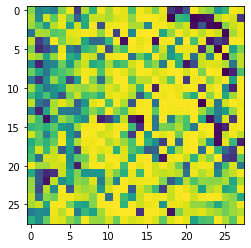

In [49]:
plt.imshow(img)